<a href="https://colab.research.google.com/github/christy726/EEG_EYE_STATE/blob/main/EEG_ETE_STATE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("/content/drive/MyDrive/UCI_EYE_STATE/EEG_Eye_State_Classification.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [7]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [8]:
df.isnull() .sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

<Axes: >

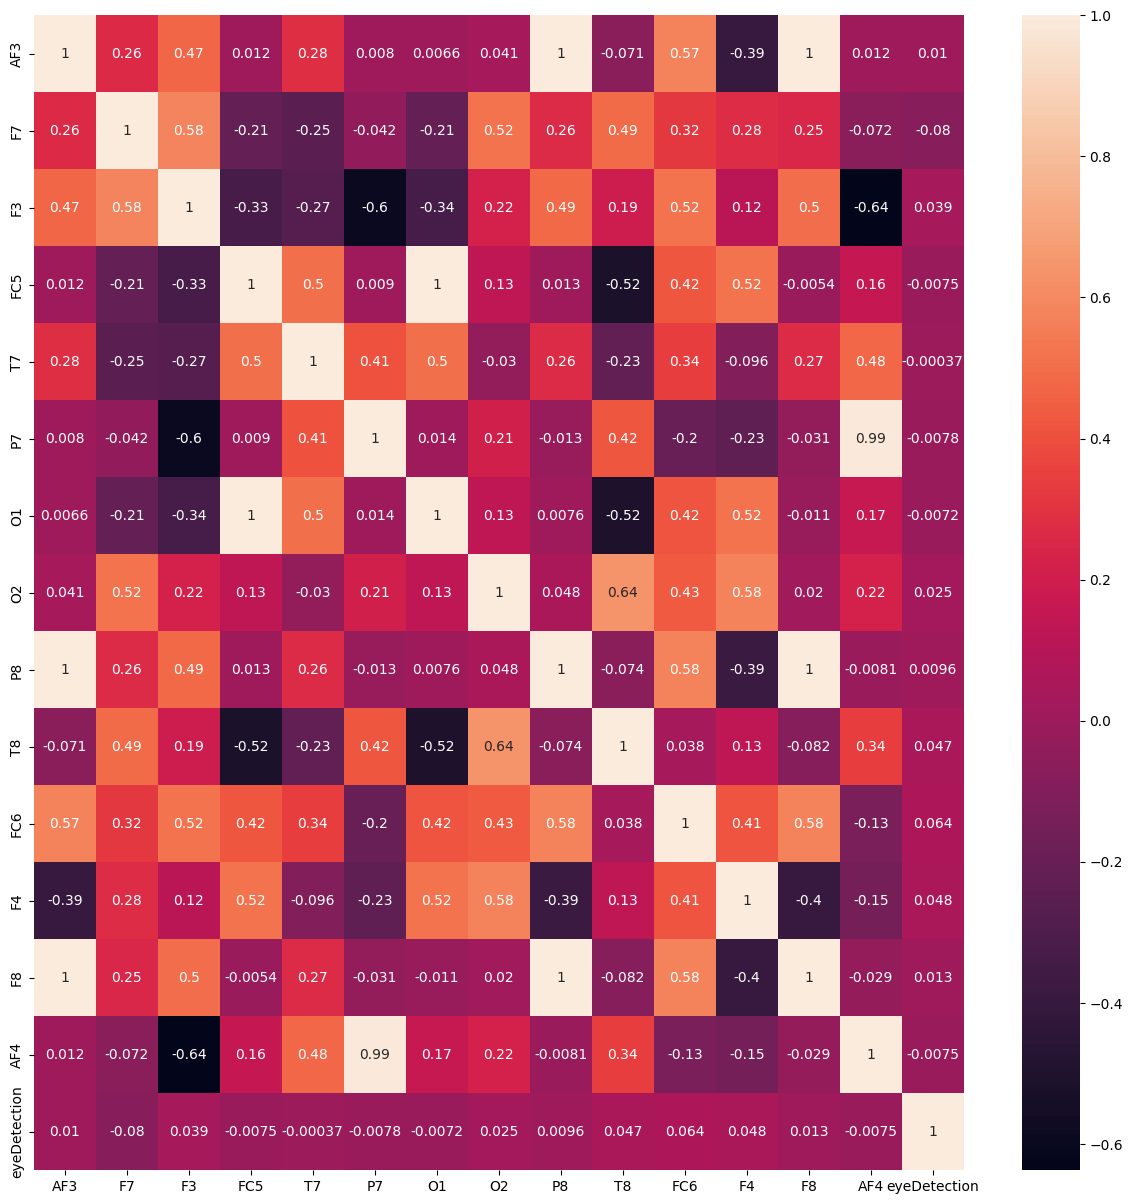

In [13]:
plt.figure(figsize = (15,15))
cor_matrix = df.corr()
sns.heatmap(cor_matrix,annot=True)

Text(0.5, 1.0, 'Target distribution')

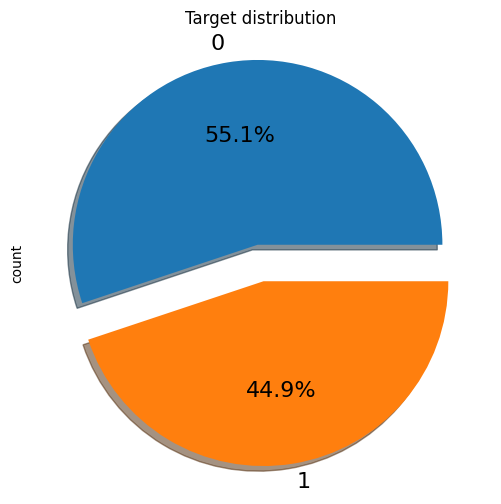

In [14]:
plt.figure(figsize=(6,6))
df['eyeDetection'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

In [15]:
data = df.copy()
y= data.pop('eyeDetection')
x= data

In [16]:
x_new = StandardScaler().fit_transform(x)

In [17]:
x_new = pd.DataFrame(x_new)
x_new.columns = x.columns

In [18]:
x_train,x_test,y_train,y_test = train_test_split(x_new,y,test_size=0.15)

In [19]:
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((12733, 14), (2247, 14), (12733,), (2247,))

In [20]:
x_train = np.array(x_train).reshape(-1,14,1)
x_test = np.array(x_test).reshape(-1,14,1)

In [21]:
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((12733, 14, 1), (2247, 14, 1), (12733,), (2247,))

In [22]:
inputs = tf.keras.Input(shape=(14,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)


lstm_1=  Bidirectional(LSTM(256, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3=  Bidirectional(LSTM(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)

flat = Flatten()(drop2)

Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 dense (Dense)               (None, 14, 64)            128       
                                                                 
 bidirectional (Bidirection  (None, 14, 512)           657408    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 14, 256)           656384    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 14, 256)           0     

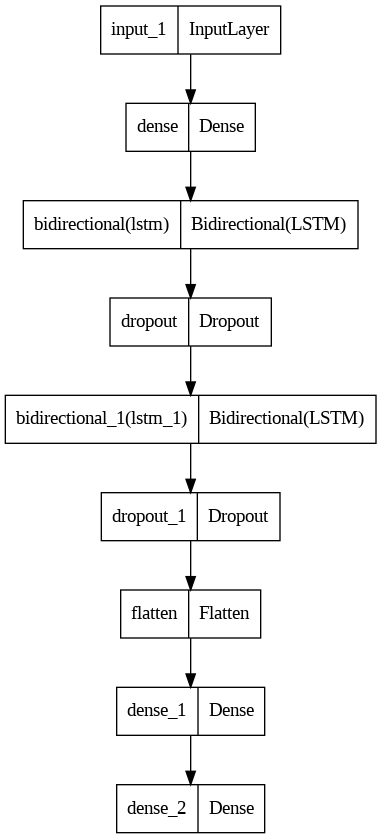

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

        model.compile(optimizer=opt_adam,
                  loss=['binary_crossentropy'],
                  metrics=['accuracy'])

        history = model.fit(x_train,y_train,
                        batch_size=20,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])

        saved_model = load_model(save_to + '_best_model.h5')

        return model,history

In [26]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5, dtype = int)
confusion_matrix(y_test, y_pred)

71/71 [==============================] - 3s 43ms/step


array([[975, 248],
       [757, 267]])

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.80      0.66      1223
           1       0.52      0.26      0.35      1024

    accuracy                           0.55      2247
   macro avg       0.54      0.53      0.50      2247
weighted avg       0.54      0.55      0.52      2247



In [34]:
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 25)

Epoch 1/25
637/637 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8421
Epoch 1: val_accuracy improved from -inf to 0.83534, saving model to ./_best_model.h5
637/637 [==============================] - 114s 163ms/step - loss: 0.3509 - accuracy: 0.8421 - val_loss: 0.3720 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 2/25
637/637 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8472
Epoch 2: val_accuracy did not improve from 0.83534
637/637 [==============================] - 101s 159ms/step - loss: 0.3350 - accuracy: 0.8472 - val_loss: 0.3922 - val_accuracy: 0.8220 - lr: 9.0484e-04
Epoch 3/25
637/637 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8598
Epoch 3: val_accuracy improved from 0.83534 to 0.84068, saving model to ./_best_model.h5
637/637 [==============================] - 107s 169ms/step - loss: 0.3132 - accuracy: 0.8598 - val_loss: 0.3652 - val_accuracy: 0.8407 - lr: 8.1873e-04
Epoch 4/25
637/637 [==============

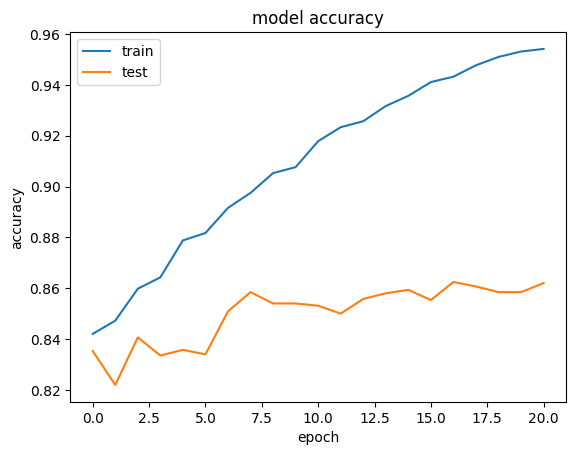

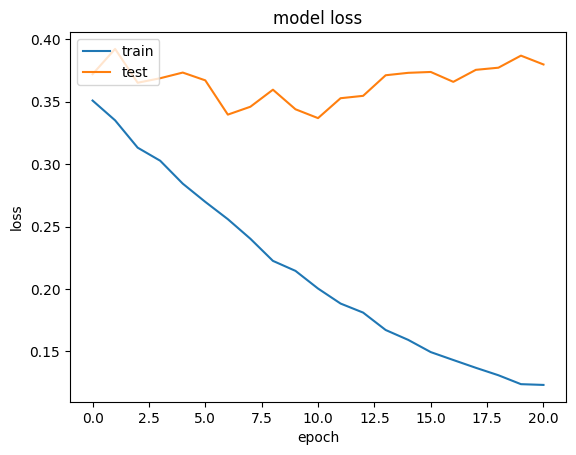

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5, dtype = int)
confusion_matrix(y_test, y_pred)

71/71 [==============================] - 5s 45ms/step


array([[1070,  153],
       [ 157,  867]])

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1223
           1       0.85      0.85      0.85      1024

    accuracy                           0.86      2247
   macro avg       0.86      0.86      0.86      2247
weighted avg       0.86      0.86      0.86      2247

